# ***Coordinate Ascent Variational Inference (CAVI)***

Let us consider the model defined by Equation (10.21)-(10-23) in Pattern Recognition and Machine Learning by Bishop, for which DGM is presented below:

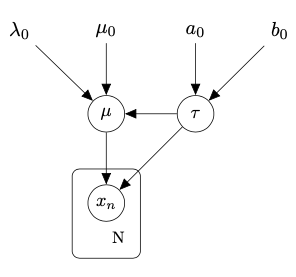

### Function that generates data for the given model:

In [13]:
import numpy as np
def generate_data(mu, tau, N):
    D = np.zeros(N)
    
    for n in range(N):
        D[n] = np.random.normal(mu, 1/np.sqrt(tau))
    
    return D

### For μ = 1, τ = 0.5, let us generate datasets with size N=10,100,1000 and plot histograms:

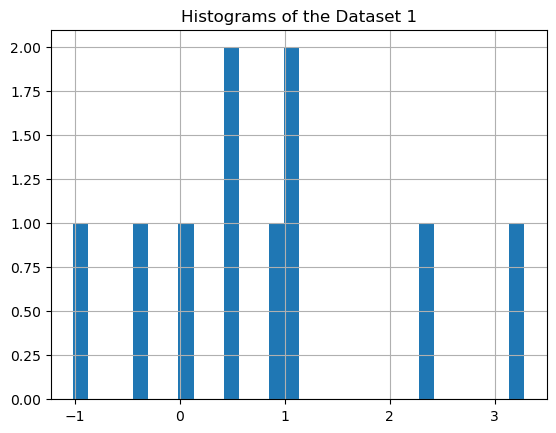

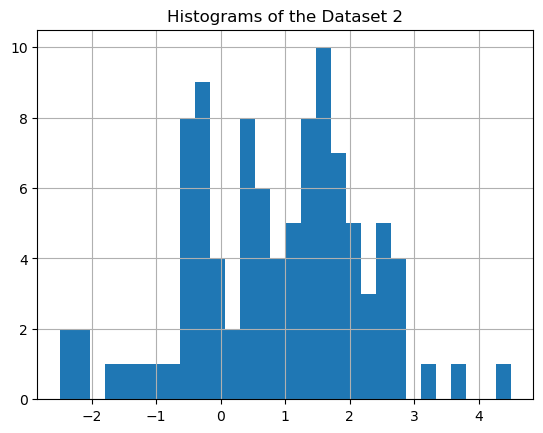

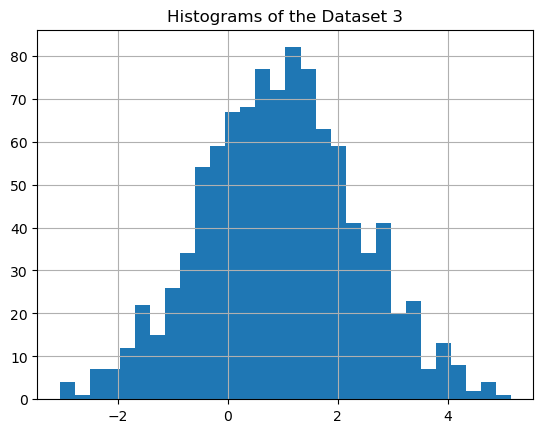

In [27]:
mu = 1
tau = 0.5

dataset_1 = generate_data(mu, tau, 10)
dataset_2 = generate_data(mu, tau, 100)
dataset_3 = generate_data(mu, tau, 1000)

# Visulaize the datasets via histograms
import matplotlib.pyplot as plt

plt.hist(dataset_1, bins=30)
plt.title('Histograms of the Dataset 1')
plt.grid()
plt.show()

plt.hist(dataset_2, bins=30)
plt.title('Histograms of the Dataset 2')
plt.grid()
plt.show()

plt.hist(dataset_3, bins=30)
plt.title('Histograms of the Dataset 3')
plt.grid()
plt.show()

### ML estimates of the variables μ and τ

In [28]:
def ML_est(data):
    N = data.shape[0]
    
    mu_ml = np.mean(data)
    
    tau_ml = N / np.sum((data - mu_ml) ** 2)
    
    return mu_ml, tau_ml

### Exact posterior

In [29]:
def compute_exact_posterior(D, a_0, b_0, mu_0, lambda_0):
    N = D.shape[0]

    a_0_star = N / 2 + a_0
    b_0_star = b_0 + 0.5 * (np.sum(D**2) + lambda_0 * mu_0**2 - (np.sum(D) + lambda_0 * mu_0)**2 / N + lambda_0)
    mu_0_star = (sum(D) + lambda_0 * mu_0) / (N + lambda_0)
    lambda_0_star = N + lambda_0

    exact_post_dist_parameters = a_0_star, b_0_star, mu_0_star, lambda_0_star
    
    return exact_post_dist_parameters

### Prior parameters

In [30]:
# prior parameters
mu_0 = 1
lambda_0 = 1
a_0 = 1
b_0 = 1

### Helper function to compute ELBO

In [2]:
import scipy.special as sp_spec

def compute_elbo (D, a_0, b_0, mu_0, lambda_0, a_N , b_N, mu_N, lambda_N):
    N = D.shape[0]
    eps = 1e-4 # for numerical stability to avoid -inf
    
    # Expected values
    E_tau = a_N / b_N
    E_log_tau = - np.log(b_N + eps) + sp_spec.digamma(a_N)
    E_mu = mu_N
    E_mu_2 = mu_N ** 2 + 1 / lambda_N
    
    # Expected log joint probability
    log_joint = 0
    # Likelihood term: log p(x | mu, tau)
    log_joint += -0.5 * N * np.log(2*np.pi)
    log_joint += 0.5 * N * E_log_tau
    log_joint += -0.5 * E_tau * (N * E_mu_2 + sum(D**2) - 2 * E_mu * sum(D))
    # Prior on mu: log p(mu | tau)
    log_joint += 0.5 * np.log(lambda_0 / 2*np.pi)
    log_joint += 0.5 * E_log_tau
    log_joint += -0.5 * lambda_0 * E_tau * (E_mu_2 + mu_0  ** 2 - 2 * mu_0 * E_mu)
    # Prior on tau: log p(tau)
    log_joint += a_0 * np.log(b_0)
    log_joint += -sp_spec.gammaln(a_0)
    log_joint += (a_0 - 1) * E_log_tau
    log_joint += -b_0 * E_tau
    
    # Variational entropy
    entropy = 0
    # Entropy of q(mu)
    entropy += 0.5 * np.log(2 * np.pi * np.e / lambda_N + eps)
    # Entropy of q(tau)
    entropy += a_N - np.log(b_N + eps) + sp_spec.gammaln(a_N + eps) + (1 - a_N) * sp_spec.digamma(a_N)

    # Combine terms for the ELBO
    elbo = log_joint + entropy
    
    return elbo

### CAVI algorithm

In [44]:
def CAVI(D, a_0, b_0, mu_0, lambda_0, max_iter=500, tol=1e-3, step_size=0.01):
    N = D.shape[0]
    
    # initial guess for the expected value of tau
    E_tau = a_0 / b_0

    # initialize
    I = max_iter
    mu_N = mu_0
    lambda_N = lambda_0
    a_N = a_0
    b_N = b_0
    elbos = [compute_elbo(D, a_0, b_0, mu_0, lambda_0, a_N, b_N, mu_N, lambda_N)]
    
    # CAVI iterations
    for i in range(max_iter - 1):
        
        # CAVI update for mu
        mu_star = (np.sum(D) + lambda_0 * mu_0) / (N + lambda_0)
        lambda_star = (N + lambda_0) * E_tau
        mu_N += step_size * (mu_star - mu_N)
        lambda_N += step_size * (lambda_star - lambda_N)
        
        # CAVI update for tau
        a_star = a_0 + (N + 1) / 2
        b_star = b_0 + 0.5 * (np.sum(D ** 2) + (N + lambda_0) * (1 / lambda_N + mu_N ** 2) - 2 * (lambda_0 * mu_0 + np.sum(D)) * mu_N + lambda_0 * mu_0 ** 2)
        a_N += step_size * (a_star - a_N)
        b_N += step_size * (b_star - b_N)

        # update exp_tau
        E_tau = a_N / b_N
        
        # ELBO update
        elbos.append(compute_elbo(D, a_0, b_0, mu_0, lambda_0, a_N , b_N, mu_N, lambda_N))

        if i > 1 and np.abs(elbos[-1] - elbos[-2]) < tol:
            break

    return a_N, b_N, mu_N, lambda_N, elbos

### Helper functions to plot the results

In [45]:
def plot_elbos(elbos, d):
    plt.plot(elbos)
    plt.xlabel('Iterations')
    plt.ylabel('ELBO')
    plt.title('ELBO Convergence for Dataset {}'.format(d))
    plt.grid()
    plt.show()

def plot_comparison(D, a_0, b_0, mu_0, lambda_0, a_N, b_N, mu_N, lambda_N, mu_ml, tau_ml, mu_range, tau_range, d):
    N = D.shape[0]
    
    # generate meshgrid for contour plot
    mu_vals = np.linspace(mu_range[0], mu_range[1], 100)
    tau_vals = np.linspace(tau_range[0], tau_range[1], 100)
    mu_grid, tau_grid = np.meshgrid(mu_vals, tau_vals)
    
    # calculate the variational distribution
    log_q_mu = -0.5 * lambda_N * (mu_grid - mu_N)**2
    log_q_tau = a_N * np.log(b_N) - sp_spec.gammaln(a_N) + (a_N - 1) * np.log(tau_grid) - b_N * tau_grid
    q_mu_tau = np.exp(log_q_tau + log_q_mu) # to avoid overflow
    
    # compute exact posterior
    exact_a, exact_b, exact_mu, exact_lambda = compute_exact_posterior(D, a_0, b_0, mu_0, lambda_0)
    log_p = (exact_a * np.log(exact_b) - sp_spec.gammaln(exact_a) - 0.5 * np.log(exact_lambda / (2 * np.pi)) + (exact_a - 0.5) * np.log(tau_grid) - exact_b * tau_grid - 0.5 * exact_lambda * tau_grid * (mu_grid - exact_mu) ** 2)
    p = np.exp(log_p) # to avoid overflow
    
    # plot contour of both distributions
    plt.figure(figsize=(10, 6))
    cs1 = plt.contour(mu_vals, tau_vals, q_mu_tau, levels=20, cmap='Blues')
    cs2 = plt.contour(mu_vals, tau_vals, p, levels=20, cmap='Reds')

    # plot ML estimate
    plt.scatter(mu_ml, tau_ml, color='black', label='ML Estimate', zorder=3)
    
    plt.xlabel('mu')
    plt.ylabel('tau')
    plt.legend()
    plt.title('Comparison of Variational Posterior, Exact Posterior, and ML Estimate for Dataset {}'.format(d))
    plt.grid()
    plt.show()

### Visualization

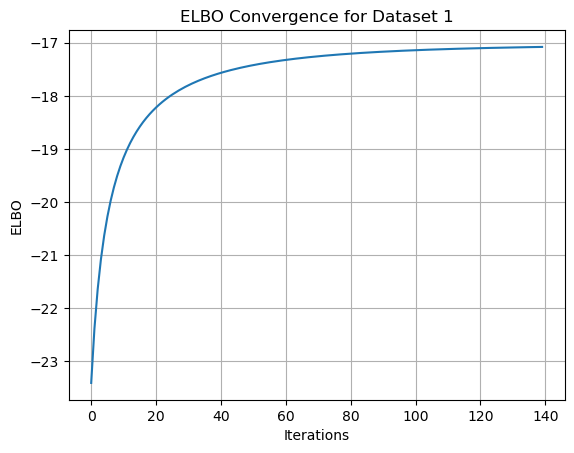

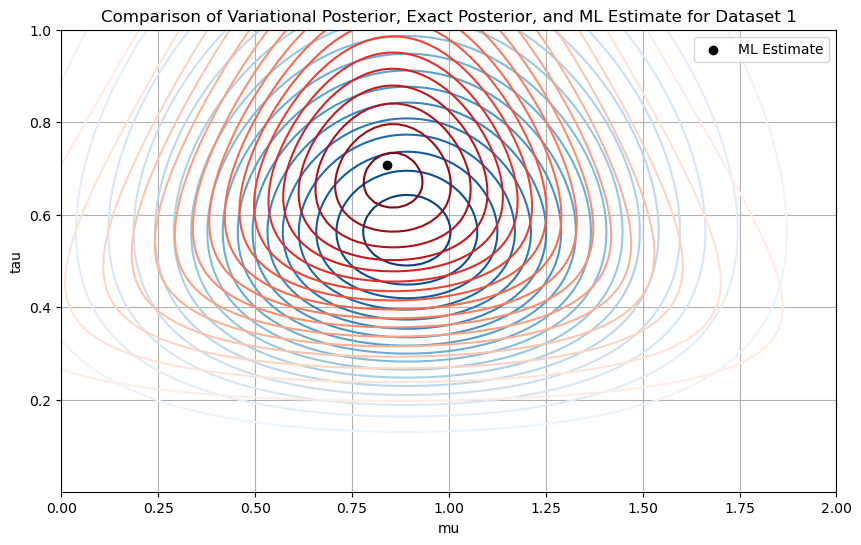

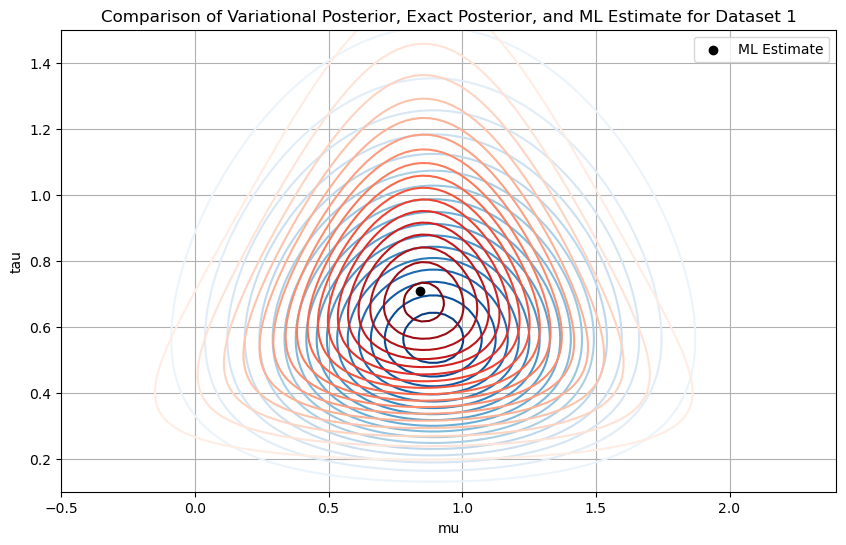

In [53]:
# compute the Maximum Likelihood Estimate (ML)
mu_ml, tau_ml = ML_est(dataset_1)

# run the CAVI algorithm to infer variational parameters
a_N, b_N, mu_N, lambda_N, elbos = CAVI(dataset_1, a_0, b_0, mu_0, lambda_0)

# plot the ELBO to check convergence
plot_elbos(elbos, 1)

# compare exact posterior with CAVI result using contour plots
plot_comparison(dataset_1, a_0, b_0, mu_0, lambda_0, a_N, b_N, mu_N, lambda_N, mu_ml, tau_ml, [0, 2], [0.001, 1], 1)
plot_comparison(dataset_1, a_0, b_0, mu_0, lambda_0, a_N, b_N, mu_N, lambda_N, mu_ml, tau_ml, [-0.5, 2.4], [0.1, 1.5], 1)

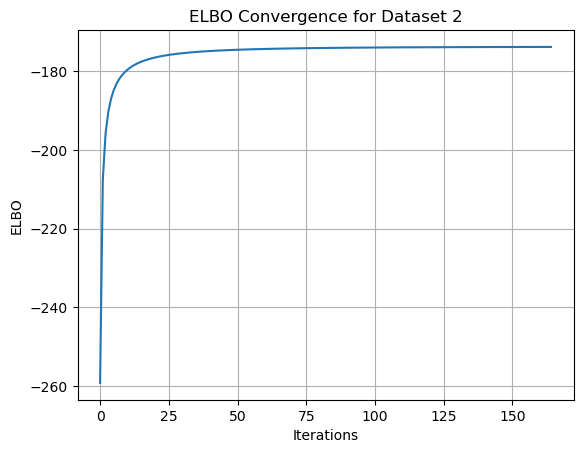

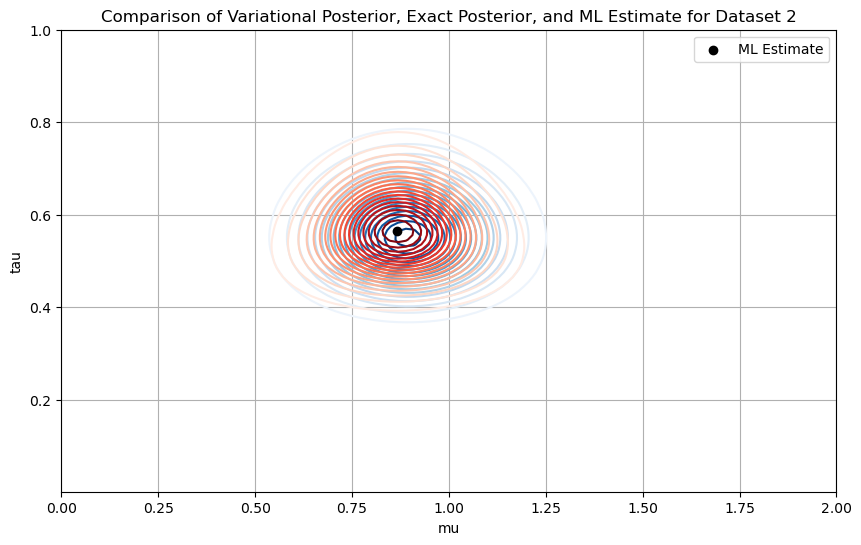

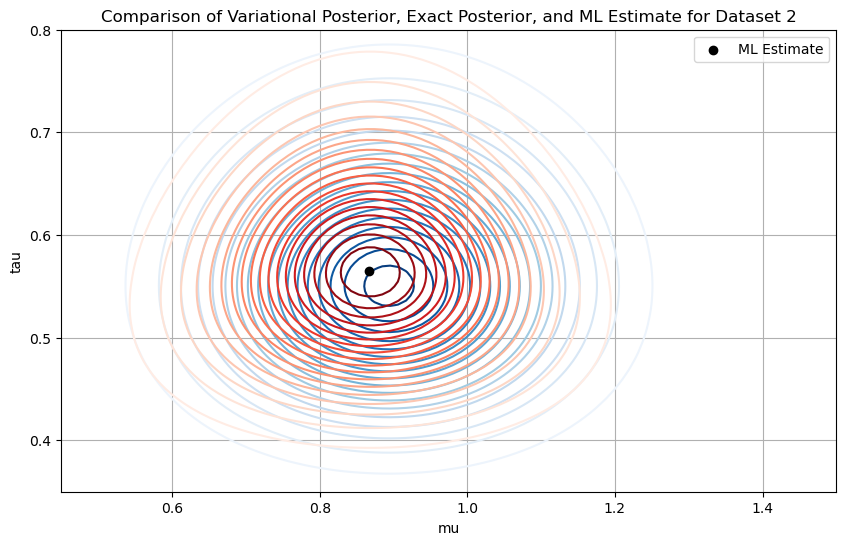

In [54]:
# compute the Maximum Likelihood Estimate (ML)
mu_ml, tau_ml = ML_est(dataset_2)

# run the CAVI algorithm to infer variational parameters
a_N, b_N, mu_N, lambda_N, elbos = CAVI(dataset_2, a_0, b_0, mu_0, lambda_0)

# plot the ELBO to check convergence
plot_elbos(elbos, 2)

# compare exact posterior with CAVI result using contour plots
plot_comparison(dataset_2, a_0, b_0, mu_0, lambda_0, a_N, b_N, mu_N, lambda_N, mu_ml, tau_ml, [0, 2], [0.001, 1], 2)
plot_comparison(dataset_2, a_0, b_0, mu_0, lambda_0, a_N, b_N, mu_N, lambda_N, mu_ml, tau_ml, [0.45, 1.5], [0.35, 0.8], 2)

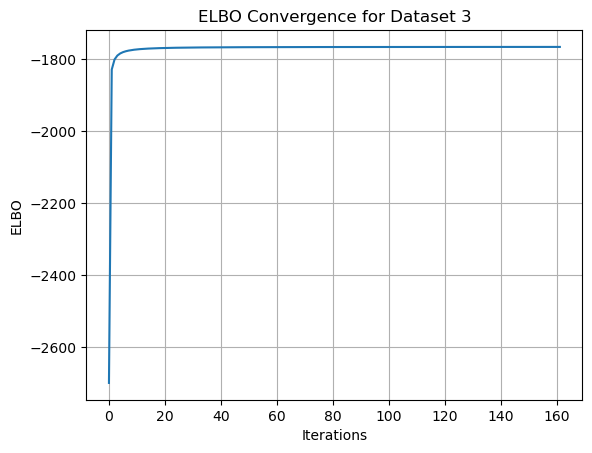

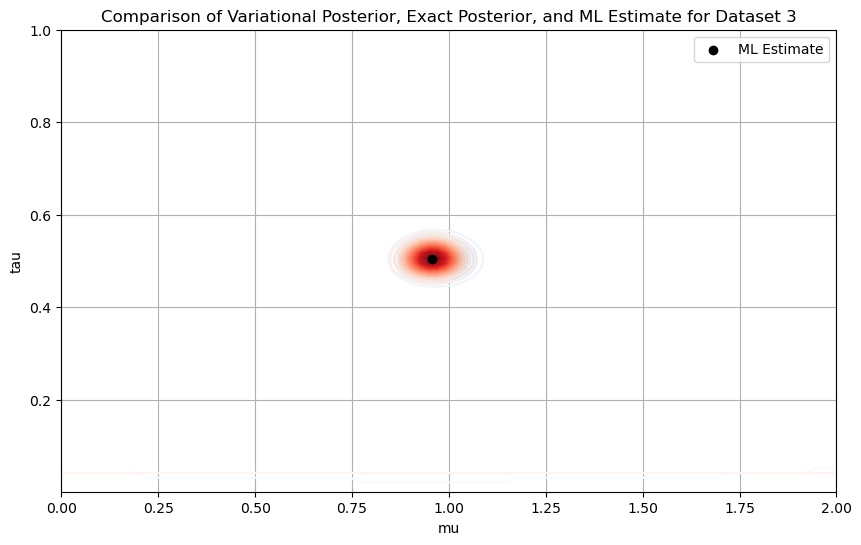

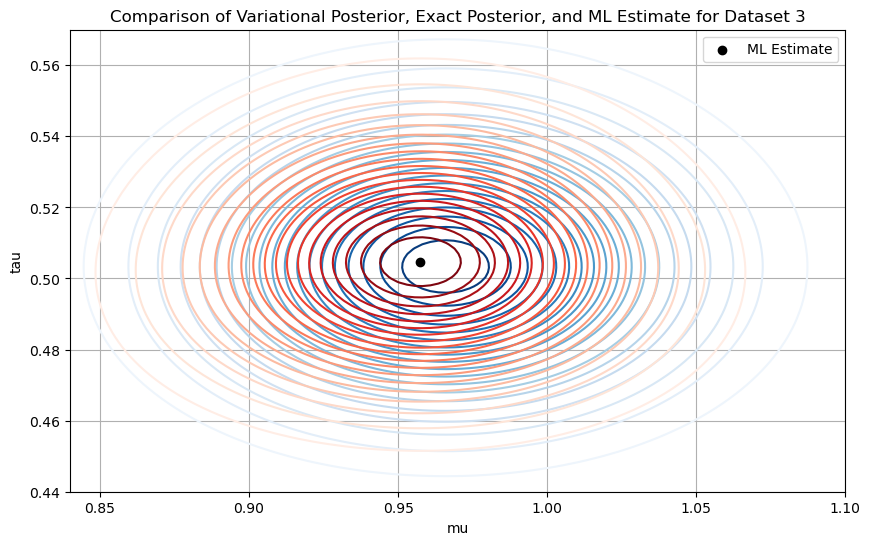

In [55]:
# compute the Maximum Likelihood Estimate (ML)
mu_ml, tau_ml = ML_est(dataset_3)

# run the CAVI algorithm to infer variational parameters
a_N, b_N, mu_N, lambda_N, elbos = CAVI(dataset_3, a_0, b_0, mu_0, lambda_0)

# plot the ELBO to check convergence
plot_elbos(elbos, 3)

# compare exact posterior with CAVI result using contour plots
plot_comparison(dataset_3, a_0, b_0, mu_0, lambda_0, a_N, b_N, mu_N, lambda_N, mu_ml, tau_ml, [0, 2], [0.001, 1], 3)
plot_comparison(dataset_3, a_0, b_0, mu_0, lambda_0, a_N, b_N, mu_N, lambda_N, mu_ml, tau_ml, [0.84, 1.1], [0.44, 0.57], 3)